# Dissipative HNNs: Ocean Data
Andrew Sosanya, Sam Greydanus | 2021

In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import interpolate
from scipy.ndimage.filters import gaussian_filter
import scipy.integrate
from functools import partial
import os, copy, time, pickle, autograd

from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

import torch
import torch.nn as nn
import torch.nn.functional as F

import deephhd
from deephhd.models import MLP, DHNN, HNN
from deephhd.train import train, get_args
from deephhd.utils import from_pickle
from deephhd.numeric import coords2fields, get_interp_model, approx_helmholtz_decomp
from deephhd.experiment_ocean.data import get_ocean_data

GRIDSIZE = 30
W = 1

## Load ocean data, process it, and make a dataset

In [3]:
def to_cos_embedding(t, w=10):
    tsteps = len(t)
    t = t.reshape(-1,1).repeat(w,-1)
#     ws = np.linspace(1,20,w-1).reshape(1,-1).repeat(tsteps,0)
    ws = np.linspace(0.9,12,w-1).reshape(1,-1).repeat(tsteps,0)
    ts = 100*np.random.rand(w-1).reshape(1,-1).repeat(tsteps,0)
    t[:,1:] = np.cos(t[:,1:]*ws + ts)
    return t

def get_ocean_data(args):
    atlantic = from_pickle('./experiment_ocean/oscar_vel2020_preprocessed.pkl')
    atlantic[:,-1] = -1 * atlantic[:,-1]  # flip y axes; we will be plotting with flipped y coordinates

    cropped_atlantic = atlantic[:,:,100:130,100:130]
    cropped_atlantic = np.nan_to_num(cropped_atlantic) #change all NaNs to 0
    x, y = np.meshgrid(range(cropped_atlantic.shape[2]), range(cropped_atlantic.shape[3]))
    xy_max = 1. * max(x.max(), y.max())

    # Reshaping our data to fit convention of x = input, y = target
    tsteps = 69
    
    t = np.linspace(-1,1,tsteps) # [tsteps]
    t = to_cos_embedding(t, w=W) # [tsteps, w]
    t = t.reshape(-1,1,1,W).repeat(cropped_atlantic.shape[-2]*cropped_atlantic.shape[-1],1)
    t = t.reshape(-1,W)
    x = np.concatenate([x.reshape(1,-1,1).repeat(tsteps,0),
                        y.reshape(1,-1,1).repeat(tsteps,0)], axis=-1)
    x = x.reshape(-1,2) # mix time and batch dimension
    x = 3 * x / xy_max  # divide by the maximum coordinate value for xs, ys
    x -= x.mean()
    
    y = np.concatenate([cropped_atlantic[:tsteps,0,:,:].reshape(tsteps,-1,1),
                        cropped_atlantic[:tsteps,1,:,:].reshape(tsteps,-1,1)], axis=-1)
    y = y.reshape(-1,2) # mix time and batch dimension
    y = (y-y.mean()) / (y.std())  # simple normalization

    # Shuffle the dataset so there aren't any order effects
    shuffle_ixs = np.random.permutation(x.shape[0])
    x, y, t = x[shuffle_ixs], y[shuffle_ixs], t[shuffle_ixs]

    # Split the dataset into it's training and testing components.
    #   axes of tensors are [dataset_size, coordinates] (where coordinates = features)
    split_ix = int(x.shape[0]*args.train_split) # train / test split
    data = {'x': x[:split_ix], 'x_test': x[split_ix:], 
            't': t[:split_ix], 't_test': t[split_ix:], 
            'dx': y[:split_ix], 'dx_test': y[split_ix:],
            'atlantic': atlantic}
    return data

args = get_args()
data = get_ocean_data(args=args)
data['x'].min(), data['x'].max(), data['dx'].min(), data['dx'].max()

(-1.5, 1.5, -4.68844359744664, 5.5050238521935695)

(69, 1)


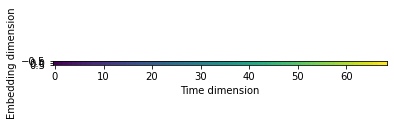

In [4]:
embeddings = []
tvals = np.sort(list(set(data['t'][:,0])))
for tval in tvals:
    ix = np.where(data['t'][:,0] == tval)[0][0]
    embeddings.append(data['t'][ix])
embeddings = np.stack(embeddings)
print(embeddings.shape)
plt.imshow(embeddings.T)
plt.xlabel('Time dimension') ; plt.ylabel('Embedding dimension') ; plt.show()

## Make the dataset

(62100, 2)


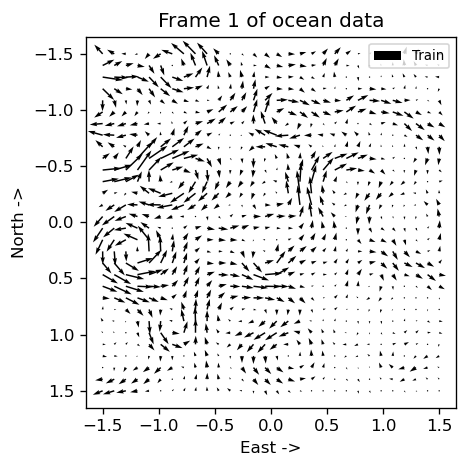

In [5]:
qkwargs = {'width': 4e-3, 'scale': 60} # quiver kwargs

args = get_args()
args.train_split = 95
data = get_ocean_data(args)
print(data['x'].shape)

fig = plt.figure(figsize=[4,4], dpi=120) # Visualize D-HNN output

plt.subplot(1,1,1)  # plotting the original composite vector field
plt.title("Frame 1 of ocean data")
plt.gca().invert_yaxis()
ixs = np.where(data['t'].squeeze() == data['t'].min())[0] # ixs of data for frame 1
plt.quiver(data['x'][ixs,0],data['x'][ixs,1], 
           data['dx'][ixs,0], -data['dx'][ixs,1], 
           color='k', label='Train', **qkwargs) #composite vector field
ixs = np.where(data['t_test'].squeeze() == data['t'].min())[0] # ixs of data for frame 1
if len(ixs) > 0:
    plt.quiver(data['x_test'][ixs,0],data['x_test'][ixs,1], 
               data['dx_test'][ixs,0], -data['dx_test'][ixs,1], 
               color='gray', label='Test', **qkwargs)
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('East ->') ; plt.ylabel('North ->')
plt.tight_layout() ; plt.show()

In [24]:
# qkwargs = {'width': 4e-3, 'scale': 60}
# args = get_args()
# args.train_split = 95
# data = get_ocean_data(args)

# fig = plt.figure(figsize=[6,3.2], dpi=140) #dpi=120 # Visualize D-HNN output
# path = './static/ocean_dataset.mp4'
# camera = Camera(fig)
# ax1, ax2 = plt.subplot(1,2,1), plt.subplot(1,2,2)

# xs = np.concatenate([data['x'], data['x_test']], axis=0)
# ts = np.concatenate([data['t'], data['t_test']], axis=0)
# dxs = np.concatenate([data['dx'], data['dx_test']], axis=0)
# tvals = np.sort(list(set(ts[:,0])))

# for i in range(len(tvals)):
#     # plot image of full atlantic
#     dxs_all = data['atlantic'][i]
#     ax1.imshow((dxs_all**2).sum(0)**.5)
#     rect = patches.Rectangle((100,100),30,30,linewidth=1,edgecolor='r',facecolor='none')
#     ax1.add_patch(rect)
    
#     # plot current vectors of cropped region
#     ixs = np.where(ts == tvals[i])[0]
#     ax2.quiver(xs[ixs,0], xs[ixs,1], dxs[ixs,0], -dxs[ixs,1], color='k', **qkwargs)
    
#     if i == 0:
#         ax1.set_title("Atlantic Ocean")
#         ax1.invert_yaxis() ; ax2.invert_yaxis()
#         ax1.set_title("Full dataset") ; ax2.set_title("Cropped region")
#         ax1.set_xlabel('East ->') ; ax1.set_ylabel('North ->')
#         ax2.set_xlabel('East ->') ; ax2.set_ylabel('North ->')
#     plt.tight_layout() ; camera.snap()
    
# plt.close()
# anim = camera.animate(blit=True, interval=140)
# anim.save(path)

In [25]:
# # Plot the video below this cell
# print('\n', path)
# mp4 = open(path,'rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# HTML("""
# <video width=800 controls>
#       <source src="%s" type="video/mp4">
# </video>
# """ % data_url)


 ./static/ocean_dataset.mp4


## Do a hand-constructed Helmholtz decomposition
We'll use the Gauss-Seidel method. It's an approximate method, but as we'll see, the lion's share of error comes from interpolating the field into a meshgrid. We use nearest neighbors for interpolation because the 'cubic' and 'linear' modes give worse results.

(30, 30, 2)


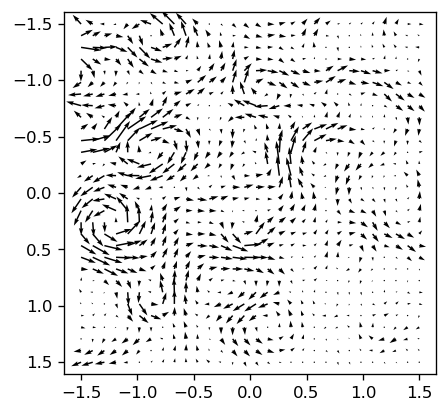

In [6]:
from scipy import interpolate
import numpy as np
from functools import partial

def get_interp_model(x, dx, method='cubic'):
    return partial(interpolate.griddata, x, dx, method=method)
    
def coords2fields(x, dx, hw=None, replace_nans=True, method='nearest', verbose=True):
    '''The x and dx coords are shuffled along the batch dimension. We need to
    run an interpolation routine in order to obtain a tensor representation of the field.'''
    if hw is None:
        h = w = GRIDSIZE # assume h=w and x=h*w
        if verbose: print('Using gridsize={}'.format(GRIDSIZE))
    else:
        (h, w) = hw
    xx = np.linspace(x[:,0].min(), x[:,1].max(), w)
    yy = np.linspace(x[:,0].min(), x[:,1].max(), h)
    x_field = np.stack(np.meshgrid(xx, yy), axis=-1)
    print(x_field.shape)
    
    interp_model = get_interp_model(x, dx, method=method)
    dx_field = interp_model(x_field)
    if replace_nans:
        dx_field[np.where(np.isnan(dx_field))] = np.nanmean(dx_field)
    return x_field, dx_field

ixs = np.where(data['t'].squeeze() == data['t'].min())[0] # ixs of data for frame 1

x, dx = coords2fields(data['x'][ixs,:2], data['dx'][ixs], hw=(GRIDSIZE,GRIDSIZE))
plt.figure(figsize=[4,4], dpi=120)
plt.gca().invert_yaxis()
plt.quiver(x[...,0], x[...,1], dx[...,0], -dx[...,1], **qkwargs)
plt.axis('equal') ; plt.show()

interp_model = get_interp_model(data['x'], data['dx'])

(30, 30)


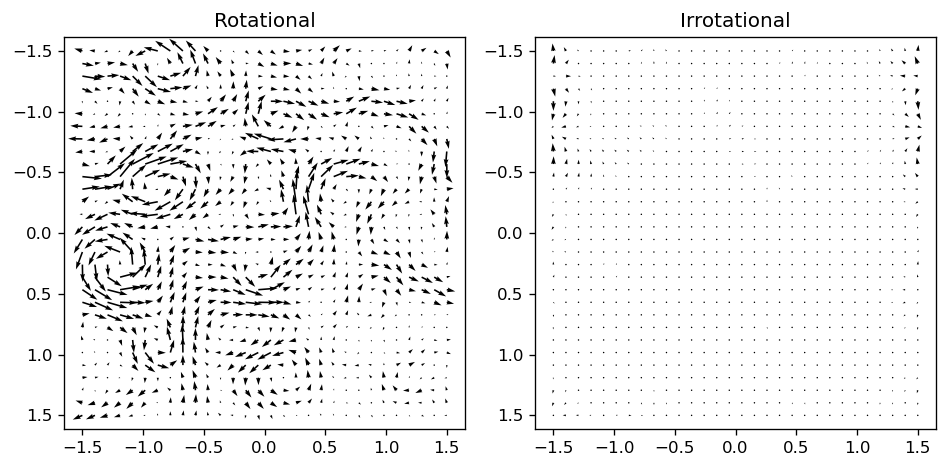

In [7]:
x_field, dx_field, dx_rot, dx_irr = approx_helmholtz_decomp(data['x'][ixs], data['dx'][ixs],
                                                            hw=(GRIDSIZE,GRIDSIZE))

fig = plt.figure(figsize=[8,4], dpi=120)
plt.subplot(1,2,1) ; plt.title('Rotational')
plt.gca().invert_yaxis()
plt.quiver(x_field[...,0], x_field[...,1], dx_rot[...,0], -dx_rot[...,1], color='k', **qkwargs)
plt.axis('equal')

plt.subplot(1,2,2) ; plt.title('Irrotational')
plt.gca().invert_yaxis()
plt.quiver(x_field[...,0], x_field[...,1], dx_irr[...,0], -dx_irr[...,1], color='k', **qkwargs)
plt.axis('equal')

plt.tight_layout() ; plt.show()

## Train models

In [8]:
args = get_args()
args.learning_rate = 3e-3
args.total_steps = 25000
args.eval_every = args.print_every = 1000

args.input_dim = 2 + W
args.device = 'cpu'
[f(args.seed) for f in [np.random.seed, torch.manual_seed, torch.cuda.manual_seed_all]]
data = get_ocean_data(args=args)
mlp_model = MLP(args.input_dim, args.output_dim, args.hidden_dim)
mlp_results = train(mlp_model, args, data)  # training the model

step 0, dt 0.006, train_loss 9.81e-01, test_loss 1.87e+00
step 1000, dt 1.854, train_loss 6.43e-01, test_loss 5.99e-01
step 2000, dt 1.877, train_loss 5.14e-01, test_loss 4.43e-01
step 3000, dt 2.043, train_loss 2.85e-01, test_loss 3.79e-01
step 4000, dt 1.960, train_loss 4.10e-01, test_loss 3.48e-01
step 5000, dt 1.818, train_loss 2.84e-01, test_loss 3.57e-01
step 6000, dt 1.912, train_loss 3.74e-01, test_loss 3.11e-01
step 7000, dt 2.077, train_loss 3.13e-01, test_loss 2.86e-01
step 8000, dt 1.889, train_loss 2.72e-01, test_loss 2.72e-01
step 9000, dt 2.064, train_loss 3.04e-01, test_loss 2.42e-01
step 10000, dt 2.112, train_loss 2.45e-01, test_loss 2.34e-01
step 11000, dt 1.940, train_loss 2.56e-01, test_loss 2.47e-01
step 12000, dt 2.015, train_loss 2.50e-01, test_loss 2.51e-01
step 13000, dt 2.094, train_loss 2.26e-01, test_loss 1.91e-01
step 14000, dt 2.022, train_loss 2.66e-01, test_loss 2.25e-01
step 15000, dt 1.869, train_loss 2.76e-01, test_loss 2.08e-01
step 16000, dt 1.903,

In [9]:
args = get_args()
args.learning_rate = 3e-3
args.total_steps = 25000
args.eval_every = args.print_every = 1000

args.input_dim = 2 + W
args.device = 'cpu'
[f(args.seed) for f in [np.random.seed, torch.manual_seed, torch.cuda.manual_seed_all]]
data = get_ocean_data(args=args)
hnn_model = HNN(args.input_dim, args.hidden_dim)
hnn_results = train(hnn_model, args, data)  # training the model

step 0, dt 0.009, train_loss 1.02e+00, test_loss 1.93e+00
step 1000, dt 4.259, train_loss 4.82e-01, test_loss 4.65e-01
step 2000, dt 3.685, train_loss 4.14e-01, test_loss 3.90e-01
step 3000, dt 3.623, train_loss 2.72e-01, test_loss 3.16e-01
step 4000, dt 3.737, train_loss 3.52e-01, test_loss 2.76e-01
step 5000, dt 4.147, train_loss 2.65e-01, test_loss 2.86e-01
step 6000, dt 3.498, train_loss 3.10e-01, test_loss 2.72e-01
step 7000, dt 3.263, train_loss 2.60e-01, test_loss 2.36e-01
step 8000, dt 3.242, train_loss 2.38e-01, test_loss 2.29e-01
step 9000, dt 3.269, train_loss 2.53e-01, test_loss 2.37e-01
step 10000, dt 3.823, train_loss 2.32e-01, test_loss 2.15e-01
step 11000, dt 3.172, train_loss 1.78e-01, test_loss 1.96e-01
step 12000, dt 3.188, train_loss 1.83e-01, test_loss 2.22e-01
step 13000, dt 3.118, train_loss 1.81e-01, test_loss 1.68e-01
step 14000, dt 3.141, train_loss 2.11e-01, test_loss 1.88e-01
step 15000, dt 3.566, train_loss 1.99e-01, test_loss 1.69e-01
step 16000, dt 4.209,

In [10]:
args = get_args()
args.learning_rate = 3e-3
args.total_steps = 25000
args.eval_every = args.print_every = 1000

args.input_dim = 2 + W
args.device = 'cpu'
[f(args.seed) for f in [np.random.seed, torch.manual_seed, torch.cuda.manual_seed_all]]
data = get_ocean_data(args=args)
dhnn_model = DHNN(args.input_dim, args.hidden_dim)
dhnn_results = train(dhnn_model, args, data)  # training the model

step 0, dt 0.019, train_loss 1.01e+00, test_loss 4.57e+00
step 1000, dt 6.770, train_loss 4.76e-01, test_loss 5.00e-01
step 2000, dt 7.067, train_loss 4.22e-01, test_loss 3.81e-01
step 3000, dt 6.219, train_loss 3.00e-01, test_loss 3.24e-01
step 4000, dt 6.205, train_loss 3.77e-01, test_loss 2.74e-01
step 5000, dt 6.825, train_loss 2.47e-01, test_loss 2.37e-01
step 6000, dt 6.693, train_loss 3.19e-01, test_loss 2.45e-01
step 7000, dt 6.504, train_loss 2.56e-01, test_loss 2.29e-01
step 8000, dt 6.558, train_loss 2.34e-01, test_loss 2.31e-01
step 9000, dt 6.256, train_loss 2.86e-01, test_loss 1.82e-01
step 10000, dt 6.259, train_loss 2.32e-01, test_loss 2.12e-01
step 11000, dt 1806.169, train_loss 1.94e-01, test_loss 1.83e-01
step 12000, dt 6.207, train_loss 1.79e-01, test_loss 2.16e-01
step 13000, dt 3418.154, train_loss 1.89e-01, test_loss 1.65e-01
step 14000, dt 11.238, train_loss 1.93e-01, test_loss 1.95e-01
step 15000, dt 31.206, train_loss 2.03e-01, test_loss 1.59e-01
step 16000, d

In [11]:
def print_stats(results):
    k = 5
    stats_last = lambda v: (np.mean(v[-k:]), np.std(v[-k:]))
    
    metrics = ['train_loss', 'test_loss']
    print("\t" + " & ".join(metrics), end='\n\t')
    for metric in metrics:
        print("{:.2e} \pm {:.2e}".format(*stats_last(results[metric])), end=' & ')
    
    print("LaTeX format", end='\n\t')
    for metric in metrics:
        print("{:.2e}".format(np.mean((results[metric])[-k:])), end=' & ')

print('D-HNN') ; print_stats(dhnn_results)
print('\nHNN') ; print_stats(hnn_results)
print('\nMLP') ; print_stats(mlp_results)

D-HNN
	train_loss & test_loss
	1.26e-01 \pm 7.27e-03 & 1.43e-01 \pm 3.51e-03 & LaTeX format
	1.26e-01 & 1.43e-01 & 
HNN
	train_loss & test_loss
	1.38e-01 \pm 6.36e-03 & 1.46e-01 \pm 1.12e-02 & LaTeX format
	1.38e-01 & 1.46e-01 & 
MLP
	train_loss & test_loss
	1.89e-01 \pm 1.65e-02 & 1.81e-01 \pm 9.98e-03 & LaTeX format
	1.89e-01 & 1.81e-01 & 

In [54]:
# smooth = gaussian_filter # name this function so it takes up less space below
# t_eval = list(range(0,args.total_steps, args.test_every))
# k, l = 2, 1

# fig = plt.figure(figsize=[3.7,3], dpi=140)
# plt.plot(smooth(mlp_results['train_loss'], k), color='r', alpha=0.15)
# plt.plot(t_eval, smooth(mlp_results['test_loss'], l), color='r', alpha=0.5, label='MLP')

# plt.plot(smooth(hnn_results['train_loss'], k), color='b', alpha=0.15)
# plt.plot(t_eval, smooth(hnn_results['test_loss'], l), color='b', alpha=0.5, label='HNN')

# plt.plot(smooth(dhnn_results['train_loss'], k), color='g', alpha=0.15)
# plt.plot(t_eval, smooth(dhnn_results['test_loss'], l), color='g', alpha=0.5, label='D-HNN')

# # plt.plot([0,5000], [baseline_err]*2, 'k--', label='Analytic D-HNN')

# plt.title('MSE') ; plt.xlabel('Train step') ; plt.yscale('log')
# plt.ylim(None, 3e-1)
# plt.legend(ncol=4, fontsize=6)
# plt.tight_layout() ; plt.show()
# fig.savefig('./static/ocean_training.pdf')

## Visualize model predictions

In [12]:
print(data['x'].shape)
[x, x_test, t, t_test] = [torch.tensor(data[v], requires_grad=True,  dtype=torch.float32)
               for v in ['x', 'x_test','t', 't_test']]
print(x.shape)
y_hat_irr, y_hat_rot = dhnn_model(x, t=t, as_separate=True)
y_hat_irr = y_hat_irr.detach().numpy()
y_hat_rot = y_hat_rot.detach().numpy()
y_hat = y_hat_rot + y_hat_irr

y_hat_irr_test, y_hat_rot_test = dhnn_model(x_test, t=t_test, as_separate=True)
y_hat_irr_test = y_hat_irr_test.detach().numpy()
y_hat_rot_test = y_hat_rot_test.detach().numpy()
y_hat_test = y_hat_rot_test + y_hat_irr_test

(49680, 2)
torch.Size([49680, 2])


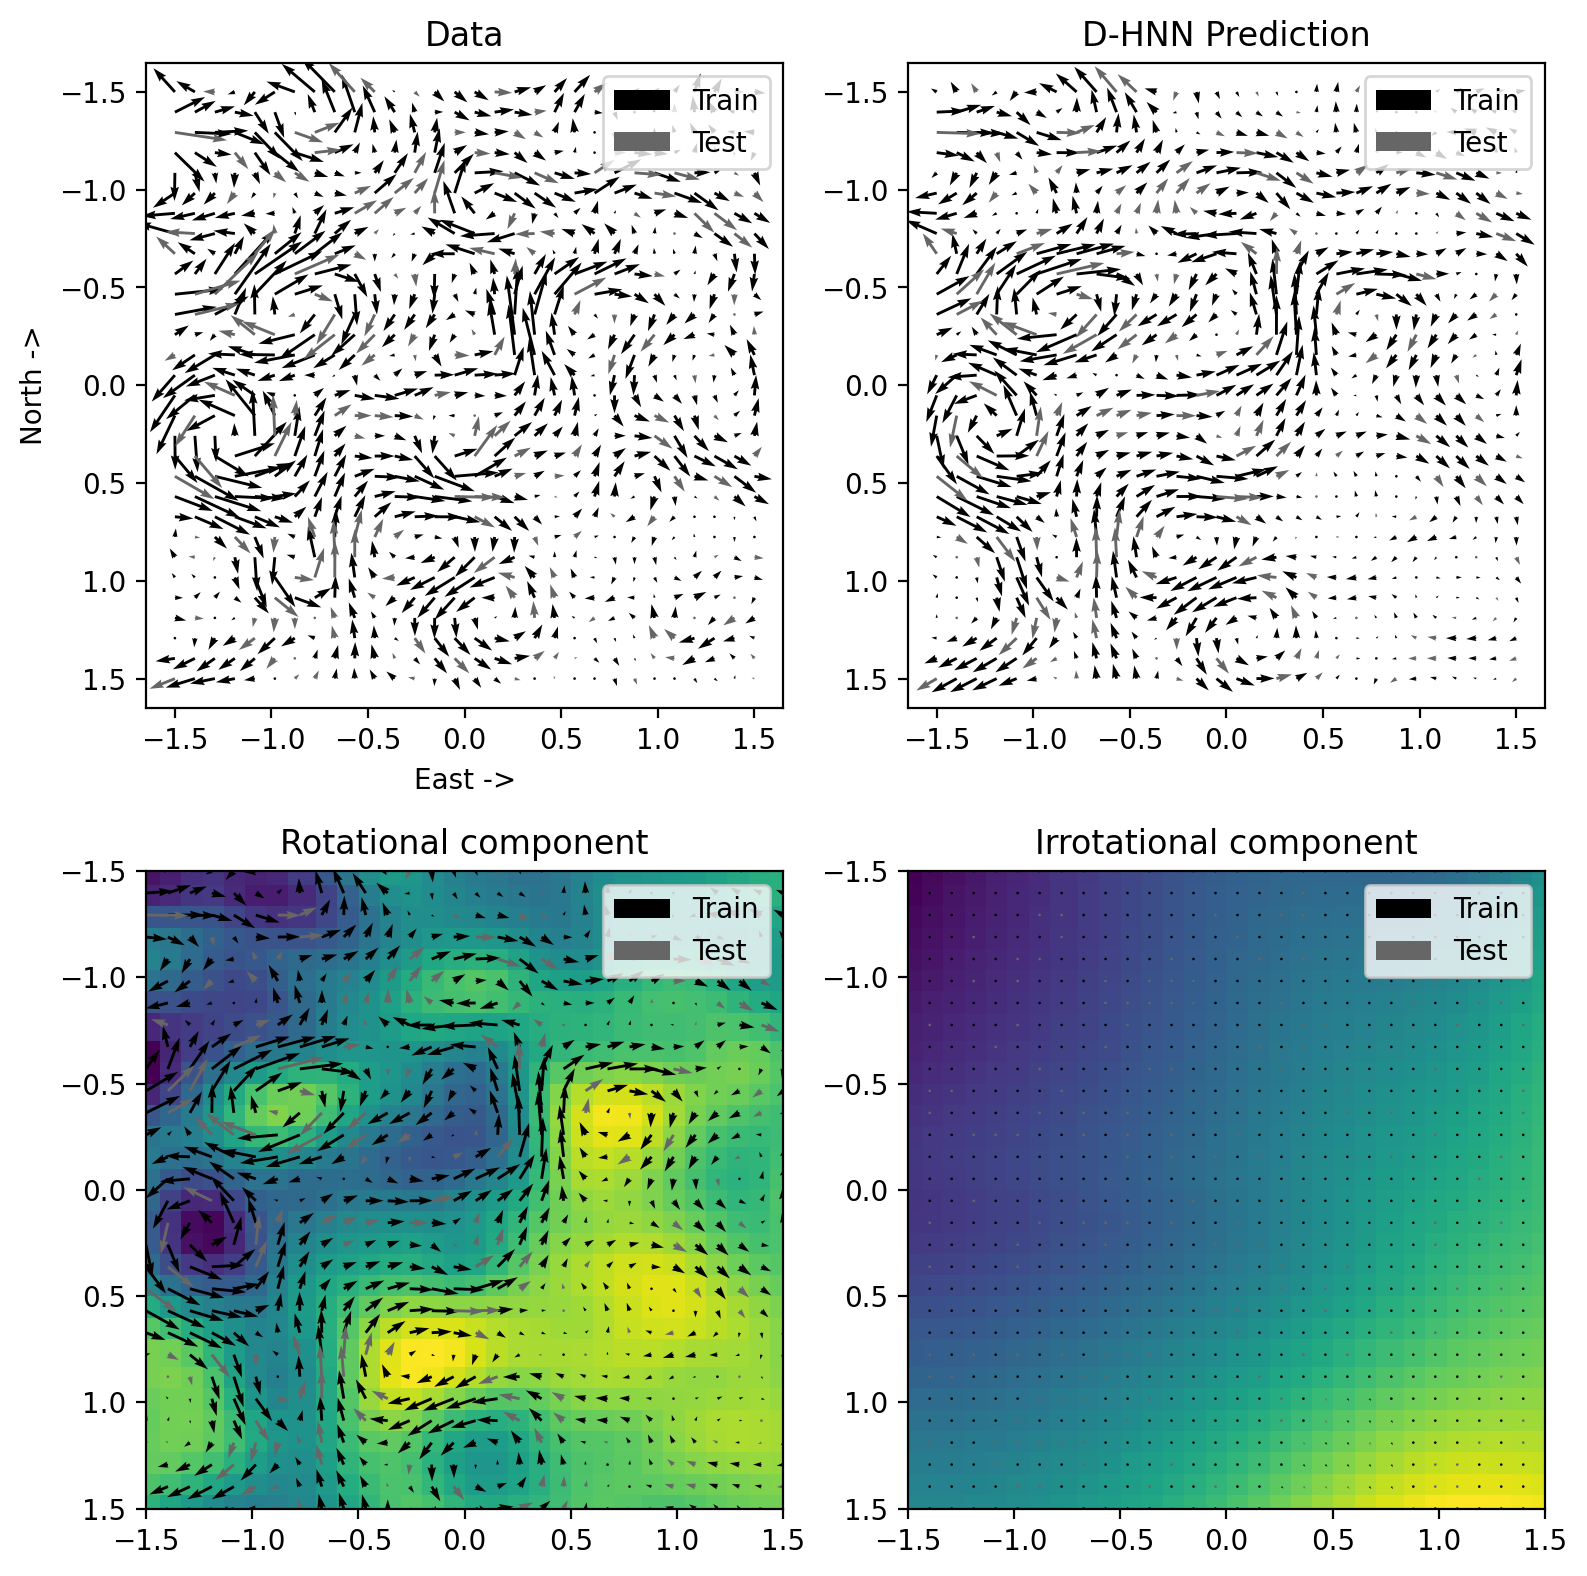

In [40]:
qkwargs = {'width': 4.5e-3, 'scale': 40} # quiver kwargs
# qkwargs = {'width': None, 'scale': None} # quiver kwargs

ixs = np.where(data['t'].squeeze() == data['t'].min())[0] # ixs of data for frame 1
tixs = np.where(data['t_test'].squeeze() == data['t'].min())[0] # ixs of data for frame 1

gray = (0.4,0.4,0.4)
fig = plt.figure(figsize=[8,8], dpi=200) # Visualize D-HNN output

plt.subplot(2,2,1)  # Plotting the predicted composite vector field
plt.title("Data")
plt.gca().invert_yaxis()
plt.quiver(data['x'][ixs,0],data['x'][ixs,1], 
           data['dx'][ixs,0], -data['dx'][ixs,1], 
           color='black', label='Train', **qkwargs) #composite vector field
plt.quiver(data['x_test'][tixs,0],data['x_test'][tixs,1], 
           data['dx_test'][tixs,0], -data['dx_test'][tixs,1], 
           color=gray, label='Test', **qkwargs)
plt.legend()
plt.xlabel('East ->') ; plt.ylabel('North ->')

plt.subplot(2,2,2)  # Plotting the predicted composite vector field
plt.title("D-HNN Prediction")
plt.gca().invert_yaxis()
plt.quiver(data['x'][ixs,0],data['x'][ixs,1], 
           y_hat[ixs,0], -y_hat[ixs,1], 
           color='black', label='Train', **qkwargs) 
plt.quiver(data['x_test'][tixs,0],data['x_test'][tixs,1], 
           y_hat_test[tixs,0], -y_hat_test[tixs,1], 
           color=gray, label='Test', **qkwargs)
plt.legend()


plt.subplot(2,2,3)  # Plotting the predicted rotational vector field
plt.title("Rotational component")
plt.gca().invert_yaxis()

plt.quiver(data['x'][ixs,0],data['x'][ixs,1], 
           y_hat_rot[ixs,0], -y_hat_rot[ixs,1], 
           color='black', label='Train', **qkwargs) #rotational vector field
plt.quiver(data['x_test'][tixs,0],data['x_test'][tixs,1], 
           y_hat_rot_test[tixs,0], -y_hat_rot_test[tixs,1], 
           color=gray, label='Test', **qkwargs)
plt.imshow(H_field,extent=[-1.5,1.5,1.5,-1.5])
plt.legend(loc='upper right')

plt.subplot(2,2,4)  # Plotting the predicted irrotational vector field
plt.title("Irrotational component")
plt.gca().invert_yaxis()
plt.quiver(data['x'][ixs,0],data['x'][ixs,1], 
           y_hat_irr[ixs,0], -y_hat_irr[ixs,1], 
           color='black', label='Train', **qkwargs) #irrotational vector field
plt.quiver(data['x_test'][tixs,0],data['x_test'][tixs,1], 
           y_hat_irr_test[tixs,0], -y_hat_irr_test[tixs,1], 
           color=gray, label='Test', **qkwargs)
plt.imshow(D_field,extent=[-1.5,1.5,1.5,-1.5])
plt.legend(loc='upper right')

plt.tight_layout() ;  plt.show()
fig.savefig('./static/ocean_dhnn.pdf')

In [17]:
# qkwargs = {'width': 4.5e-3, 'scale': 40}

# fig = plt.figure(figsize=[9,3.3], dpi=150) #dpi=120 # Visualize HHD output
# path = './static/ocean_hhd.mp4'
# camera = Camera(fig)
# ax1, ax2, ax3 = plt.subplot(1,3,1), plt.subplot(1,3,2), plt.subplot(1,3,3)

# xs = np.concatenate([data['x'], data['x_test']], axis=0)
# ts = np.concatenate([data['t'], data['t_test']], axis=0)
# dxs = np.concatenate([data['dx'], data['dx_test']], axis=0)
# tvals = np.sort(list(set(data['t'][:,0])))

# for i in range(len(tvals)):
#     ixs = np.where(data['t'] == tvals[i])[0]
#     tixs = np.where(data['t_test'] == tvals[i])[0]
    
#     # composite
#     ax1.quiver(data['x'][ixs,0],data['x'][ixs,1], y_hat[ixs,0], -y_hat[ixs,1], **qkwargs)
#     ax1.quiver(data['x_test'][tixs,0], data['x_test'][tixs,1],
#                y_hat_test[tixs,0], -y_hat_test[tixs,1], **qkwargs)

#     # conservative
#     ax2.quiver(data['x'][ixs,0],data['x'][ixs,1], y_hat_rot[ixs,0], -y_hat_rot[ixs,1], **qkwargs)
#     ax2.quiver(data['x_test'][tixs,0], data['x_test'][tixs,1],
#                y_hat_rot_test[tixs,0], -y_hat_rot_test[tixs,1], **qkwargs)
    
#     # dissipative
#     ax3.quiver(data['x'][ixs,0],data['x'][ixs,1], y_hat_irr[ixs,0], -y_hat_irr[ixs,1], **qkwargs)
#     ax3.quiver(data['x_test'][tixs,0], data['x_test'][tixs,1],
#                y_hat_irr_test[tixs,0], -y_hat_irr_test[tixs,1], **qkwargs)
    
#     if i == 0:
#         ax1.set_title("D-HNN Prediction") ; ax2.set_title("Rotational") ; ax3.set_title("Irrotational")
#         ax1.invert_yaxis() ; ax2.invert_yaxis() ; ax3.invert_yaxis()
#         ax1.set_xlabel('East ->') ; ax1.set_ylabel('North ->')
# #         ax2.set_xlabel('East ->') ; ax2.set_ylabel('North ->')
# #         ax3.set_xlabel('East ->') ; ax3.set_ylabel('North ->')
#     plt.tight_layout() ; camera.snap()
#     print(i, end='\r')
    
# plt.close()
# anim = camera.animate(blit=True, interval=140)
# anim.save(path)

In [18]:
# # Plot the video below this cell
# print('\n', path)
# mp4 = open(path,'rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# HTML("""
# <video width=800 controls>
#       <source src="%s" type="video/mp4">
# </video>
# """ % data_url)


 ./static/ocean_hhd.mp4


## Let's visualize the scalar fields

In [25]:
def get_interp_model(x, dx, method='cubic'):
    return partial(interpolate.griddata, x, dx, method=method)
    
def coords2fields(x, dx, hw=None, replace_nans=True, method='nearest', verbose=True):
    '''The x and dx coords are shuffled along the batch dimension. We need to
    run an interpolation routine in order to obtain a tensor representation of the field.'''
    if hw is None:
        h = w = GRIDSIZE # assume h=w and x=h*w
        if verbose: print('Using gridsize={}'.format(GRIDSIZE))
    else:
        (h, w) = hw
    xx = np.linspace(x[:,0].min(), x[:,1].max(), w)
    yy = np.linspace(x[:,0].min(), x[:,1].max(), h)
    x_field = np.stack(np.meshgrid(xx, yy), axis=-1)
    print(x_field.shape)
    
    interp_model = get_interp_model(x, dx, method=method)
    dx_field = interp_model(x_field)
    if replace_nans:
        dx_field[np.where(np.isnan(dx_field))] = np.nanmean(dx_field)
    return x_field, dx_field

In [28]:
def interpolate_scalar(x, S):
    w, h = (GRIDSIZE, GRIDSIZE)
    xx = np.linspace(x[:,0].min(), x[:,0].max(), 3*w)
    yy = np.linspace(x[:,1].min(), x[:,1].max(), 3*h)
    x_field = np.stack(np.meshgrid(xx, yy), axis=-1)

    interp_model = get_interp_model(x, S, method='nearest')
    return interp_model(x_field)

x = data['x'] # [B x 2]
x_ = torch.tensor(x, requires_grad=True,  dtype=torch.float32)
t_ = -torch.ones(*x_.shape[:-1], W)
D = dhnn_model.mlp_d(x_, t=t_).cpu().detach().numpy() # [B x 1]
H = dhnn_model.mlp_h(x_, t=t_).cpu().detach().numpy() # [B x 1]

D_field = interpolate_scalar(x, D)[...,0]
H_field = interpolate_scalar(x, H)[...,0]

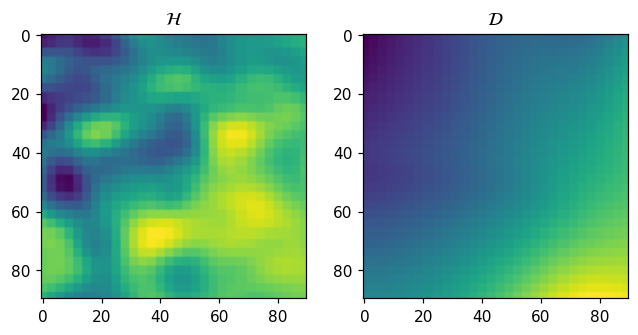

In [29]:
fig = plt.figure(figsize=[6,3], dpi=110) # Visualize D-HNN output

plt.subplot(1,2,1)
plt.title('$\mathcal{H}$')
plt.gca().invert_yaxis()
plt.imshow(H_field)

plt.subplot(1,2,2)
plt.title('$\mathcal{D}$')
plt.gca().invert_yaxis()
plt.imshow(D_field)

plt.tight_layout() ;  plt.show()

## Let's make a movie of this effect

In [22]:
# fig = plt.figure(figsize=[6,3.2], dpi=140) #dpi=120 # Visualize D-HNN output
# path = './static/ocean_dhnn_scalars.mp4'
# camera = Camera(fig)
# ax1, ax2 = plt.subplot(1,2,1), plt.subplot(1,2,2)

# tvals = np.sort(list(set(data['t'][:,0])))

# for i in range(len(tvals)):
#     x = data['x'] # [B x 2]
#     x_ = torch.tensor(x, requires_grad=True,  dtype=torch.float32)
#     t = to_cos_embedding(tvals[i:i+1], w=W)
#     t_ = torch.tensor(t, dtype=torch.float32) * torch.ones_like(x_[...,:1])
#     print(i, end='\r')
#     D = dhnn_model.mlp_d(x_, t=t_).cpu().detach().numpy() # [B x 1]
#     H = dhnn_model.mlp_h(x_, t=t_).cpu().detach().numpy() # [B x 1]

#     D_field = interpolate_scalar(x, D)[...,0]
#     H_field = interpolate_scalar(x, H)[...,0]
    
#     ax1.imshow(H_field)
#     ax2.imshow(D_field)
    
#     if i == 0:
#         ax1.set_title('$\mathcal{H}$') ; ax1.invert_yaxis()
#         ax1.set_xlabel('East ->') ; ax1.set_ylabel('North ->')
#         ax2.set_title('$\mathcal{D}$') ; ax2.invert_yaxis()
#         ax2.set_xlabel('East ->') ; ax2.set_ylabel('North ->')
#     plt.tight_layout() ; camera.snap()
    
# plt.close()
# anim = camera.animate(blit=True, interval=140)
# anim.save(path)

In [23]:
# # Plot the video below this cell
# print('\n', path)
# mp4 = open(path,'rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# HTML("""
# <video width=800 controls>
#       <source src="%s" type="video/mp4">
# </video>
# """ % data_url)


 ./static/ocean_dhnn_scalars.mp4
